In [151]:
import pandas as pd
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import lightgbm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

TARGET_DICT = {'OTHER': 0,
               'PROFANITY': 1,
               'SEXIST': 2,
               'RACIST': 3,
               'INSULT': 4}

TARGET_INV_DICT = {TARGET_DICT[key]: key for key in TARGET_DICT.keys()}

In [32]:
input_df = pd.read_csv("../data/evaluation/dbmdz-bert-base-turkish-128k-uncased_OOF.csv")

In [37]:
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis",
             tokenizer=tokenizer,
             model=model,
            batch_size=256)

p = sa(input_df["text"].to_list())

input_df["sentiment_score"] = [elm["score"] if (elm["label"] == "positive") else (1-elm["score"]) for elm in p]

In [49]:
input_df

,id,text,is_offensive,target,text_len,target_label,public_fold,private_fold,pred,OTHER,...,SEXIST,RACIST,INSULT,sentiment_score,INSULT_stage2,OTHER_stage2,PROFANITY_stage2,RACIST_stage2,SEXIST_stage2,pred_stage2
0,81c11060-a240-4d54-841b-9e2916039e85,çürük dişli,1,INSULT,11,4,1,0,INSULT,0.000426,...,0.000227,0.000272,0.997680,0.006425,0.999589,0.000014,0.000334,0.000051,0.000013,INSULT
1,be80ebbf-b322-4c3b-afa1-94932ea80731,bu adamın islama ve müslümanlara verdiği zarar...,1,RACIST,67,3,3,0,RACIST,0.001526,...,0.000174,0.997362,0.000632,0.032792,0.000027,0.000099,0.000013,0.999859,0.000002,RACIST
2,f99e2513-83ed-4076-ac72-b9e2cff3f049,erkekler zora gelmez,1,SEXIST,20,2,2,0,SEXIST,0.000641,...,0.998332,0.000142,0.000455,0.951145,0.000009,0.000140,0.000008,0.000002,0.999840,SEXIST
3,83ed2b2e-b815-4f36-9fc4-80a9050cf2d0,utanmazın götüne kazık sokmuşlar bu tıkırtı ne...,1,PROFANITY,65,1,4,0,PROFANITY,0.000137,...,0.000244,0.000355,0.002424,0.060117,0.006106,0.000010,0.993834,0.000023,0.000027,PROFANITY
4,d93e05f7-bfdd-4cdb-99d8-3048761b30ff,otomasyon< sistemlerine= doğrudan bağlanabilir,0,OTHER,46,0,4,0,OTHER,0.997976,...,0.000296,0.000412,0.000913,0.954609,0.000367,0.999589,0.000014,0.000012,0.000018,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12406,71eedfa1-8fa6-425c-b982-258c3b29c003,uyuma taklidi yapan tehlikeli bir hayvanın göz...,0,OTHER,63,0,4,1,INSULT,0.289295,...,0.000514,0.013548,0.694580,0.067033,0.697077,0.226479,0.001085,0.074957,0.000403,INSULT
12407,b38eed16-6501-4563-8b33-ff2e634bb8e5,yolda at kavga eden üç oğlan çocuğu görür,0,OTHER,41,0,4,1,SEXIST,0.021074,...,0.976557,0.000512,0.001255,0.680637,0.063279,0.163314,0.000372,0.000080,0.772955,SEXIST
12408,c8a051a8-94ef-4b64-a48e-54d0fa4f8323,sizin köpeklerinizin burnu bile daha iyi koku ...,0,OTHER,66,0,4,0,INSULT,0.001813,...,0.000328,0.000574,0.995998,0.909390,0.998107,0.001385,0.000219,0.000065,0.000224,INSULT
12409,513a7e6d-4207-4a16-9b47-972f26e23cfe,hayalleri gerçek etmek için birisinin delilik ...,0,OTHER,90,0,1,4,INSULT,0.148764,...,0.000906,0.025520,0.778602,0.908651,0.122840,0.450106,0.031383,0.395211,0.000461,OTHER


In [119]:
q_count = 5
input_df['q_text_len'] = pd.qcut(input_df['text_len'], q=q_count, labels=np.arange(q_count))
input_df['q_sentiment_score'] = pd.qcut(input_df['sentiment_score'], q=q_count, labels=np.arange(q_count))

In [166]:
x_col = [
    "sentiment_score",
    "text_len",
    "OTHER",
    "PROFANITY",
    "SEXIST",
    "RACIST",
    "INSULT"
]

y_col = "target"

fold_col = "public_fold"

Training.. Fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.00it/s]


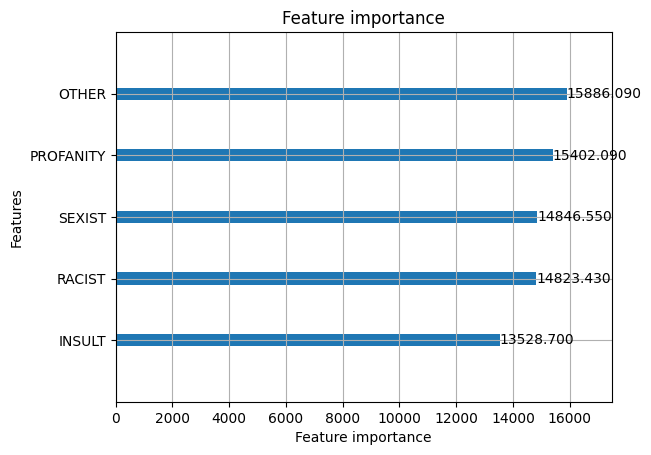

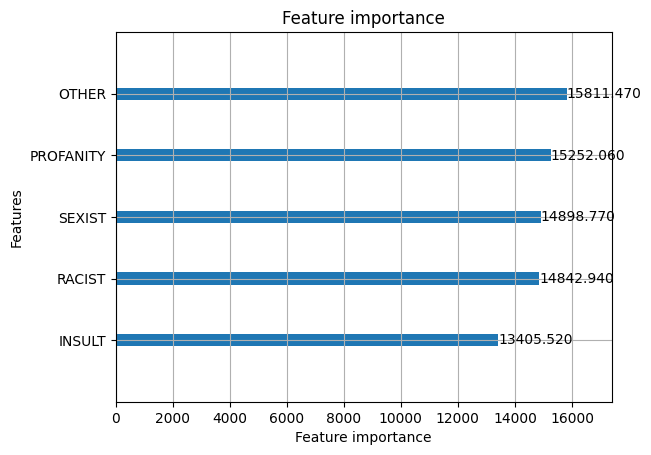

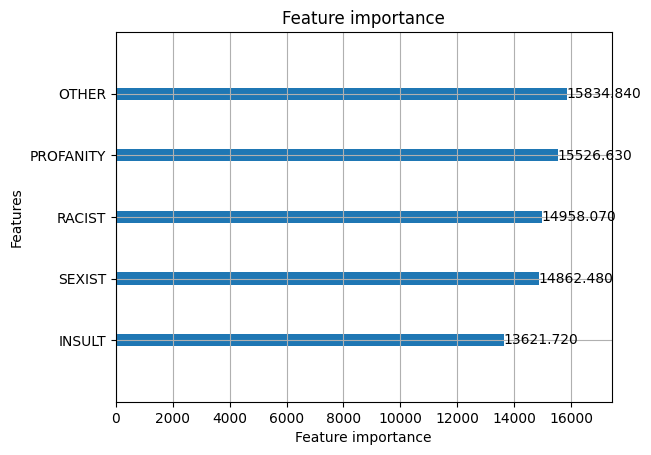

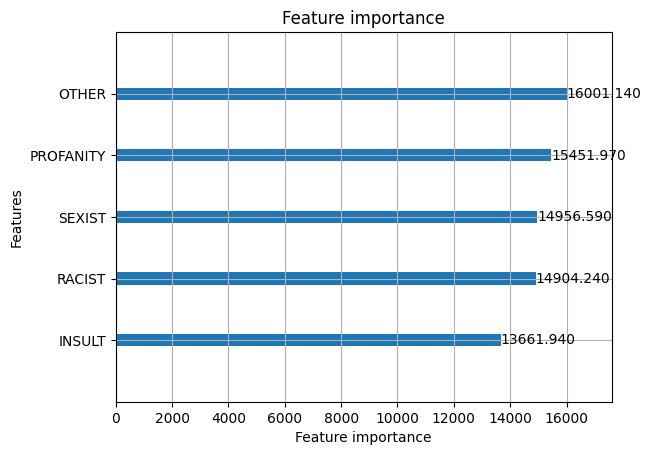

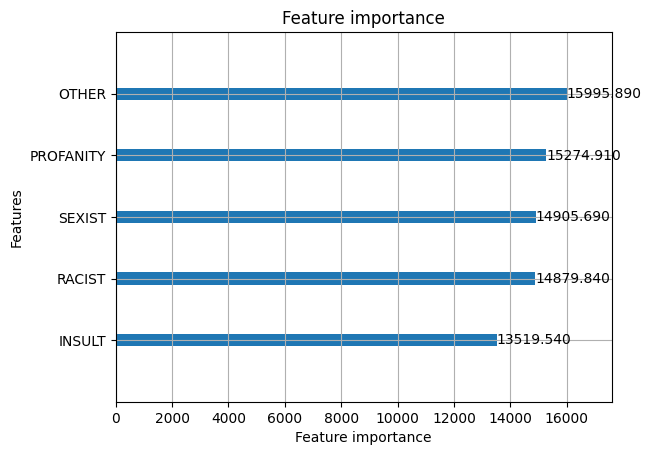

In [179]:
for fold_id in tqdm(sorted(input_df[fold_col].unique()), desc="Training.. Fold"):
    X_train = input_df[input_df[fold_col] != fold_id][x_col]
    y_train = input_df[input_df[fold_col] != fold_id][y_col]
    X_val = input_df[input_df[fold_col] == fold_id][x_col]
    y_val = input_df[input_df[fold_col] == fold_id][y_col]

    val_idx = y_val.index.tolist()

    model = LGBMClassifier(max_depth=1, n_estimators=3)

    model.fit(X_train,
              y_train)

    preds = model.predict(X_val)
    pred_probas = model.predict_proba(X_val)
    lightgbm.plot_importance(model, importance_type="gain")
    input_df.loc[val_idx, [elm + "_stage2" for elm in sorted(TARGET_DICT.keys())]] = pred_probas


    input_df.loc[val_idx, "pred_stage2"] = preds

In [180]:
print(classification_report(input_df["target"],
                            input_df["pred"],
                            output_dict=False,
                            digits=4))

              precision    recall  f1-score   support

      INSULT     0.9147    0.9056    0.9101      2393
       OTHER     0.9564    0.9453    0.9508      3528
   PROFANITY     0.9621    0.9621    0.9621      2376
      RACIST     0.9539    0.9666    0.9602      2033
      SEXIST     0.9481    0.9654    0.9567      2081

    accuracy                         0.9477     12411
   macro avg     0.9470    0.9490    0.9480     12411
weighted avg     0.9477    0.9477    0.9476     12411



In [181]:
print(classification_report(input_df["target"],
                            input_df["pred_stage2"],
                            output_dict=False,
                            digits=4))

              precision    recall  f1-score   support

      INSULT     0.9043    0.9198    0.9120      2393
       OTHER     0.9580    0.9447    0.9513      3528
   PROFANITY     0.9621    0.9604    0.9612      2376
      RACIST     0.9546    0.9621    0.9584      2033
      SEXIST     0.9605    0.9587    0.9596      2081

    accuracy                         0.9481     12411
   macro avg     0.9479    0.9491    0.9485     12411
weighted avg     0.9483    0.9481    0.9482     12411

